In [3]:
import os
import shutil
import re
from skimage.feature import hog
import cv2
import numpy as np
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm

In [32]:
# Caminhos das pastas originais
orig_base = 'DataSet'
orig_no_dr = os.path.join(orig_base, 'Healthy')
orig_with_dr = os.path.join(orig_base, 'Diabetic Retinopathy')

# Caminhos das pastas destino
dest_base = 'dataset_selecionado'
dest_no_dr = os.path.join(dest_base, 'no_DR')
dest_with_dr = os.path.join(dest_base, 'with_DR')

# Cria pastas destino se não existirem
os.makedirs(dest_no_dr, exist_ok=True)
os.makedirs(dest_with_dr, exist_ok=True)
# Define número de imagens por classe

n_images = 400

In [33]:
# Função para limpar pasta destino
def limpar_pasta(pasta):
    if os.path.exists(pasta):
        for f in os.listdir(pasta):
            file_path = os.path.join(pasta, f)
            if os.path.isfile(file_path):
                os.unlink(file_path)
    else:
        os.makedirs(pasta)

In [34]:

# Caminhos de entrada e saída
input_base = 'dataset_selecionado'
output_bases = {
    '256': 'resized_256',
    '128': 'resized_128'
}
tamanhos = {
    '256': (256, 256),
    '128': (128, 128)
}

# Rótulos/classes
classes = ['no_DR', 'with_DR']

# Criar pastas de saída, se não existirem
for size_key, out_base in output_bases.items():
    for cls in classes:
        os.makedirs(os.path.join(out_base, cls), exist_ok=True)

# Função para redimensionar e salvar
def redimensionar_e_salvar(input_path, output_path, tamanho):
    imagens = [img for img in os.listdir(input_path) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
    for img in imagens:
        caminho_img = os.path.join(input_path, img)
        imagem = cv2.imread(caminho_img)
        if imagem is None:
            print(f'Erro ao ler: {caminho_img}')
            continue
        imagem_redim = cv2.resize(imagem, tamanho)
        cv2.imwrite(os.path.join(output_path, img), imagem_redim)

# Executar redimensionamento para cada classe e tamanho
for cls in classes:
    input_path = os.path.join(input_base, cls)
    for size_key, tamanho in tamanhos.items():
        output_path = os.path.join(output_bases[size_key], cls)
        print(f'Redimensionando {cls} para {tamanho}...')
        redimensionar_e_salvar(input_path, output_path, tamanho)


Redimensionando no_DR para (256, 256)...
Redimensionando no_DR para (128, 128)...
Redimensionando with_DR para (256, 256)...
Redimensionando with_DR para (128, 128)...


In [35]:

# Pastas de entrada (e também de saída, pois sobrescreve)
bases = {
    '256': 'resized_256',
    '128': 'resized_128'
}
classes = ['no_DR', 'with_DR']

# Conversão em cada pasta
def converter_para_cinza(pasta):
    imagens = [img for img in os.listdir(pasta) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
    for img in imagens:
        caminho_img = os.path.join(pasta, img)
        imagem = cv2.imread(caminho_img)
        if imagem is None:
            print(f'Erro ao ler: {caminho_img}')
            continue
        imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(caminho_img, imagem_gray)  # sobrescreve

# Aplicar para todas as pastas
for size_key, base_path in bases.items():
    for cls in classes:
        pasta = os.path.join(base_path, cls)
        print(f'Convertendo para tons de cinza: {pasta}')
        converter_para_cinza(pasta)


Convertendo para tons de cinza: resized_256\no_DR
Convertendo para tons de cinza: resized_256\with_DR
Convertendo para tons de cinza: resized_128\no_DR
Convertendo para tons de cinza: resized_128\with_DR


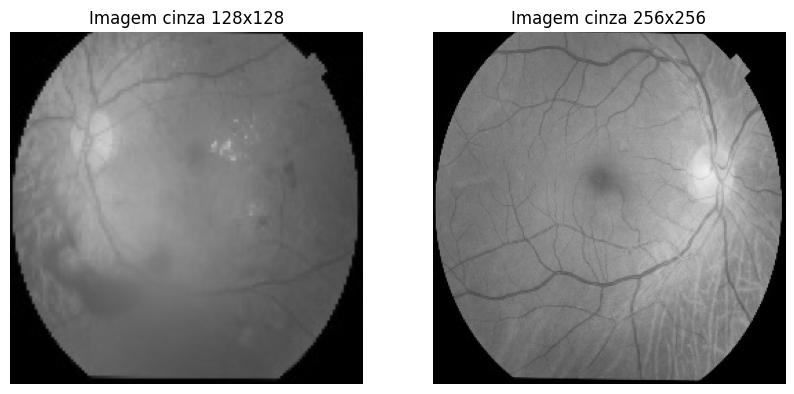

In [37]:
import matplotlib.pyplot as plt

# Caminho para uma das pastas
pasta256 = 'resized_256/no_DR'
pasta128 = 'resized_128/with_DR'

# Seleciona a primeira imagem da pasta
imagens1 = [img for img in os.listdir(pasta128)]
imagens2 = [img for img in os.listdir(pasta256)]


img_path_128 = os.path.join(pasta128, imagens1[0])
img_path_256 = os.path.join(pasta256, imagens2[0])

imagem128 = cv2.imread(img_path_128)  # já deve estar em tons de cinza
imagem256 = cv2.imread(img_path_256)  # já deve estar em tons de cinza



# Exibe a imagem com matplotlib

# Criar o subplot 2x2
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(imagem128, cmap='gray')
axs[0].set_title('Imagem cinza 128x128')
axs[0].axis('off')

axs[1].imshow(imagem256, cmap='gray')
axs[1].set_title('Imagem cinza 256x256')
axs[1].axis('off')

plt.show()

In [40]:
# Pastas base de entrada (já em grayscale)
bases = {
    '256': 'resized_256',
    '128': 'resized_128'
}

# Pastas base de saída para CLAHE
saida_clahe = {
    '256': 'clahe_256',
    '128': 'clahe_128'
}

classes = ['no_DR', 'with_DR']


# Criar objeto CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Função para aplicar CLAHE e salvar em outra pasta
def aplicar_clahe(input_pasta, output_pasta):
    imagens = [img for img in os.listdir(input_pasta) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img in imagens:
        caminho = os.path.join(input_pasta, img)
        imagem = cv2.imread(caminho, cv2.IMREAD_GRAYSCALE)
        if imagem is None:
            print(f'Erro ao ler: {caminho}')
            continue
        imagem_clahe = clahe.apply(imagem)
        cv2.imwrite(os.path.join(output_pasta, img), imagem_clahe)

# Aplicar CLAHE para todas as pastas
for size_key in bases:
    base_entrada = bases[size_key]
    base_saida = saida_clahe[size_key]
    
    for cls in classes:
        pasta_entrada = os.path.join(base_entrada, cls)
        pasta_saida = os.path.join(base_saida, cls)
        os.makedirs(pasta_saida, exist_ok=True)
        
        print(f'Aplicando CLAHE: {pasta_entrada} → {pasta_saida}')
        aplicar_clahe(pasta_entrada, pasta_saida)




Aplicando CLAHE: resized_256\no_DR → clahe_256\no_DR
Aplicando CLAHE: resized_256\with_DR → clahe_256\with_DR
Aplicando CLAHE: resized_128\no_DR → clahe_128\no_DR
Aplicando CLAHE: resized_128\with_DR → clahe_128\with_DR


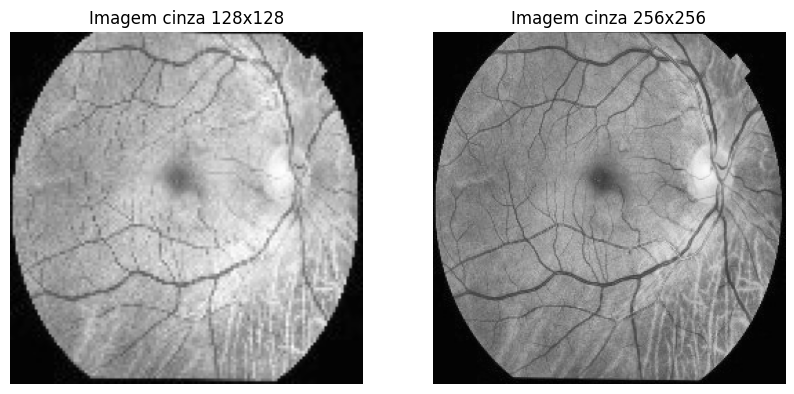

In [42]:
# Caminho para uma das pastas
pasta256 = 'clahe_256/no_DR'
pasta128 = 'clahe_128/no_DR'

def Amostra_imagems(pasta1, pasta2):
    # Seleciona a primeira imagem da pasta
    imagens1 = [img for img in os.listdir(pasta1)]
    imagens2 = [img for img in os.listdir(pasta2)]


    img_path_128 = os.path.join(pasta1, imagens1[0])
    img_path_256 = os.path.join(pasta2, imagens2[0])

    imagem128 = cv2.imread(img_path_128)  # já deve estar em tons de cinza
    imagem256 = cv2.imread(img_path_256)  # já deve estar em tons de cinza


    # Exibe a imagem com matplotlib

    # Criar o subplot 2x2
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))

    axs[0].imshow(imagem128, cmap='gray')
    axs[0].set_title('Imagem cinza 128x128')
    axs[0].axis('off')

    axs[1].imshow(imagem256, cmap='gray')
    axs[1].set_title('Imagem cinza 256x256')
    axs[1].axis('off')

    plt.show()

Amostra_imagems(pasta128, pasta256)

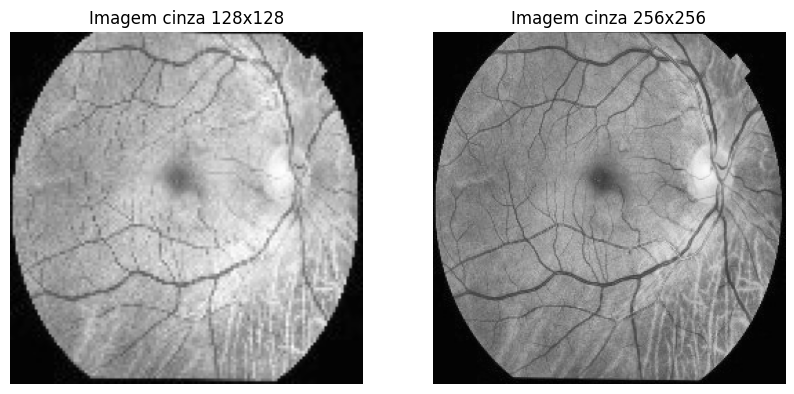

In [ ]:
# Caminho para uma das pastas
pasta256 = 'clahe_256/no_DR'
pasta128 = 'clahe_128/no_DR'

# Seleciona a primeira imagem da pasta
imagens1 = [img for img in os.listdir(pasta128)]
imagens2 = [img for img in os.listdir(pasta256)]


img_path_128 = os.path.join(pasta128, imagens1[0])
img_path_256 = os.path.join(pasta256, imagens2[0])

imagem128 = cv2.imread(img_path_128)  # já deve estar em tons de cinza
imagem256 = cv2.imread(img_path_256)  # já deve estar em tons de cinza


# Exibe a imagem com matplotlib

# Criar o subplot 2x2
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(imagem128, cmap='gray')
axs[0].set_title('Imagem cinza 128x128')
axs[0].axis('off')

axs[1].imshow(imagem256, cmap='gray')
axs[1].set_title('Imagem cinza 256x256')
axs[1].axis('off')

plt.show()

In [43]:
# Bases com CLAHE
bases_clahe = {
    '256': 'clahe_256',
    '128': 'clahe_128'
}

# Subpastas de saída dentro de cada classe
sobel_subpastas = {
    '256': 'sobel_256',
    '128': 'sobel_128'
}

classes = ['no_DR', 'with_DR']

# Função para aplicar Sobel e salvar na subpasta
def aplicar_sobel(input_pasta, output_subpasta):
    imagens = [img for img in os.listdir(input_pasta) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img in imagens:
        caminho = os.path.join(input_pasta, img)
        imagem = cv2.imread(caminho, cv2.IMREAD_GRAYSCALE)
        if imagem is None:
            print(f'Erro ao ler: {caminho}')
            continue

        # Sobel nos eixos X e Y
        sobelx = cv2.Sobel(imagem, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(imagem, cv2.CV_64F, 0, 1, ksize=3)

        # Gradiente de magnitude
        grad = cv2.magnitude(sobelx, sobely)
        grad = cv2.convertScaleAbs(grad)

        cv2.imwrite(os.path.join(output_subpasta, img), grad)

# Aplica Sobel e salva nas subpastas internas
for size_key in bases_clahe:
    base_entrada = bases_clahe[size_key]
    subpasta_saida = sobel_subpastas[size_key]

    for cls in classes:
        pasta_clahe = os.path.join(base_entrada, cls)
        pasta_sobel = os.path.join(pasta_clahe, subpasta_saida)
        os.makedirs(pasta_sobel, exist_ok=True)

        print(f'Aplicando Sobel em {pasta_clahe} → salvando em {pasta_sobel}')
        aplicar_sobel(pasta_clahe, pasta_sobel)

Aplicando Sobel em clahe_256\no_DR → salvando em clahe_256\no_DR\sobel_256
Aplicando Sobel em clahe_256\with_DR → salvando em clahe_256\with_DR\sobel_256
Aplicando Sobel em clahe_128\no_DR → salvando em clahe_128\no_DR\sobel_128
Aplicando Sobel em clahe_128\with_DR → salvando em clahe_128\with_DR\sobel_128


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Julio\AppData\Local\Temp\ipykernel_11572\1618540953.py:1: SyntaxWarning: invalid escape sequence '\s'
  pasta_sobels_128 = 'clahe_128/no_DR\sobel_128'
C:\Users\Julio\AppData\Local\Temp\ipykernel_11572\1618540953.py:2: SyntaxWarning: invalid escape sequence '\s'
  pasta_sobels_256 = 'clahe_256/no_DR\sobel_256'


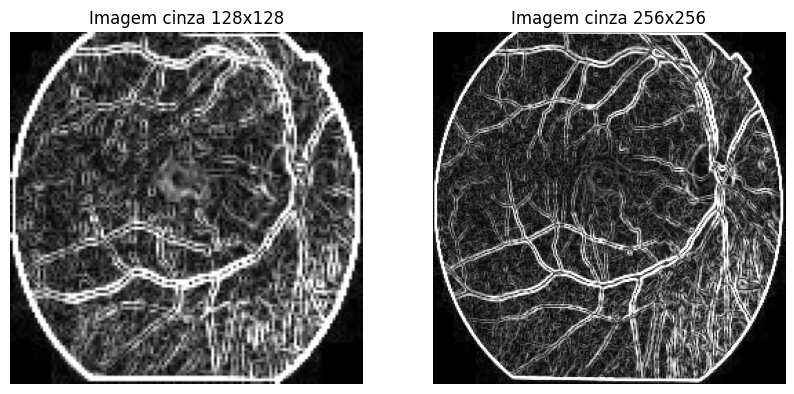

In [46]:
pasta_sobels_128 = 'clahe_128/no_DR\sobel_128'
pasta_sobels_256 = 'clahe_256/no_DR\sobel_256'


Amostra_imagems(pasta_sobels_128, pasta_sobels_256)

Aplicando filtro de bordas: resized_256\no_DR
Aplicando filtro de bordas: resized_256\with_DR
Aplicando filtro de bordas: resized_128\no_DR
Aplicando filtro de bordas: resized_128\with_DR


Agora com as imagens separadas e processadas, começa o aprendizado.

In [4]:
# Estrutura de entrada
bases = {
    '256': {
        'path': 'clahe_256',
        'sobel_sub': 'sobel_256',
        'output_csv': 'hog_features_256.csv'
    },
    '128': {
        'path': 'clahe_128',
        'sobel_sub': 'sobel_128',
        'output_csv': 'hog_features_128.csv'
    }
}

classes = ['no_DR', 'with_DR']

# Parâmetros do HOG (você pode ajustar depois se quiser)
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys'
}

# Função para processar imagens com HOG
def extrair_features_hog(pasta_sobel, label):
    features_lista = []
    imagens = [img for img in os.listdir(pasta_sobel) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img_nome in imagens:
        img_path = os.path.join(pasta_sobel, img_nome)
        imagem = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if imagem is None:
            print(f'Erro ao ler: {img_path}')
            continue

        features = hog(imagem, **hog_params)
        features_lista.append(np.append(features, label))  # adiciona o rótulo ao final
    return features_lista

# Loop para processar 128 e 256
for size_key, info in bases.items():
    todas_features = []

    for cls in classes:
        pasta_sobel = os.path.join(info['path'], cls, info['sobel_sub'])
        print(f'Extraindo HOG de {pasta_sobel}...')
        classe_features = extrair_features_hog(pasta_sobel, cls)
        todas_features.extend(classe_features)

    # Converte para DataFrame e salva CSV
    df = pd.DataFrame(todas_features)
    df.to_csv(info['output_csv'], index=False, header=False)
    print(f'Arquivo salvo: {info["output_csv"]}')

Extraindo HOG de clahe_256\no_DR\sobel_256...
Extraindo HOG de clahe_256\with_DR\sobel_256...
Arquivo salvo: hog_features_256.csv
Extraindo HOG de clahe_128\no_DR\sobel_128...
Extraindo HOG de clahe_128\with_DR\sobel_128...
Arquivo salvo: hog_features_128.csv


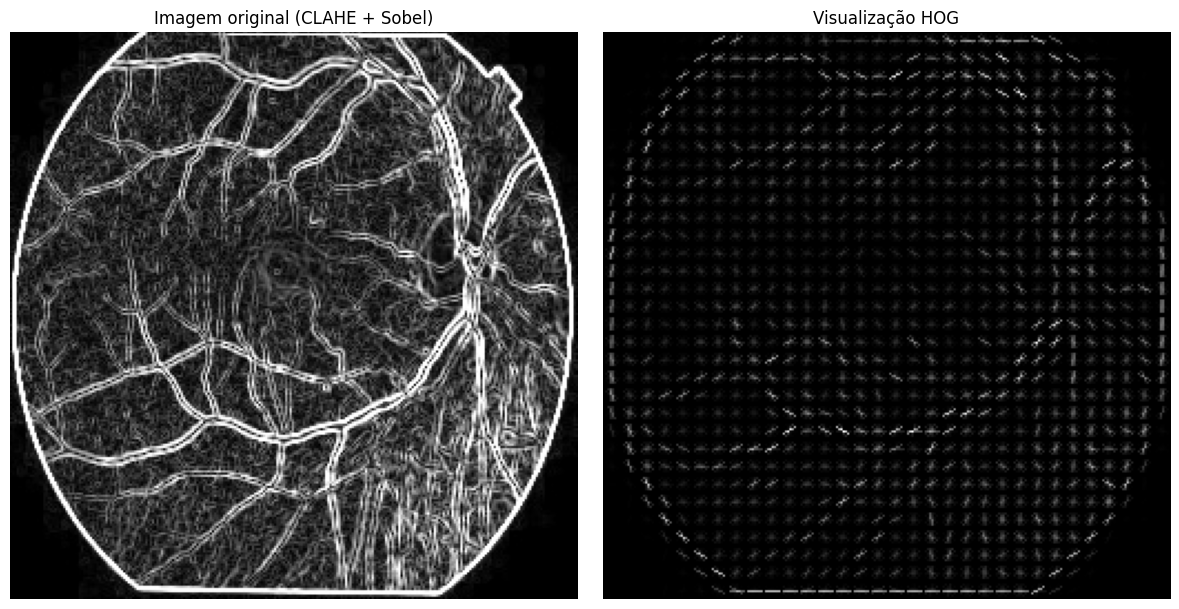

In [5]:

# Caminho de uma imagem qualquer para visualizar HOG
img_path = 'clahe_256/no_DR/sobel_256/Healthy1.jpg'

# Carrega em grayscale
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Aplica HOG com visualização
features, hog_image = hog(
    img,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True
)

# Mostra imagem original e imagem com gradientes HOG
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Imagem original (CLAHE + Sobel)')
axs[0].axis('off')

axs[1].imshow(hog_image, cmap='gray')
axs[1].set_title('Visualização HOG')
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# Carrega o CSV com os vetores HOG
df = pd.read_csv('hog_features_256.csv', header=None)

# Separa atributos e rótulos
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Codifica os rótulos (no_DR → 0, with_DR → 1)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Aplica PCA para reduzir a dimensionalidade para 10
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Cria novo DataFrame com os dados reduzidos e o rótulo
df_pca = pd.DataFrame(X_pca)
df_pca['label'] = y_encoded

# Salva novo CSV
df_pca.to_csv('hog_pca_256.csv', index=False, header=False)
print('Arquivo com PCA salvo: hog_pca_256.csv')


Arquivo com PCA salvo: hog_pca_256.csv


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Carrega os dados com PCA (pode usar o original se quiser)
df = pd.read_csv('hog_pca_256.csv', header=None)

# Separa atributos e rótulos
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Divide em treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treina o k-NN para vários valores de k
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'k = {k}: Acurácia = {acc:.4f}')


k = 1: Acurácia = 0.8875
k = 2: Acurácia = 0.8750
k = 3: Acurácia = 0.8875
k = 4: Acurácia = 0.8875
k = 5: Acurácia = 0.9083
k = 6: Acurácia = 0.9042
k = 7: Acurácia = 0.8917
k = 8: Acurácia = 0.8833
k = 9: Acurácia = 0.8917
k = 10: Acurácia = 0.8875
